In [1]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
def dB(x):
    return 10*np.log10(x)

In [3]:
def bandpass(f):
    sq = (2 < f) & (5 > f)
    x = np.arange(-10, 10, 0.1)
    kernel = exp(-x**2/10)
    s = np.convolve(sq, kernel, mode="same")
    s /= np.max(s)
    s += 0.035*np.cos(f/0.2)*s
    s += 0.02*np.sin(f**1.4/0.2+1)*s
    s /= np.sum(s)
    return s

def make_noise(band, num_chunks):
    freq_noise = np.vstack([np.hstack([band[::-1], band])]*num_chunks)
    phase_noise = np.random.uniform(0, 2*pi, freq_noise.shape)
    freq_noise = freq_noise * np.exp(1j*phase_noise)
    return np.real(np.fft.fft(freq_noise))

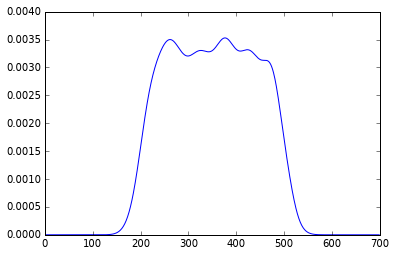

In [4]:
freqs = np.arange(0, 7, 0.01)
bp = bandpass(freqs)
plt.plot(bp)

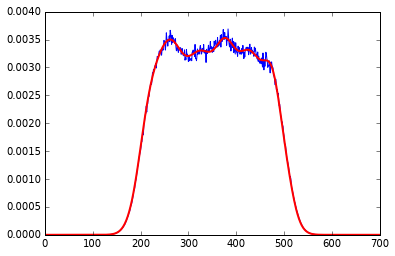

In [5]:
def average_spectrum(s, normalize=True):
    reconstructed_spectrum = np.average(np.abs(np.fft.rfft(s)), axis=0)[::-1]
    if normalize: reconstructed_spectrum /= np.sum(reconstructed_spectrum)
    return reconstructed_spectrum

n = make_noise(bp, 500)
reconstructed_spectrum = average_spectrum(n)
plt.plot(reconstructed_spectrum)
plt.plot(bp, 'r-', lw=2)

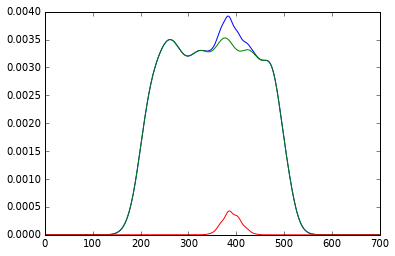

In [6]:
def signal(f):
    sq = (3.7 < f) & (4.1 > f)
    x = np.arange(-10, 10, 0.1)
    kernel = exp(-x**2/5)
    s = np.convolve(sq, kernel, mode="same")
    s /= np.max(s)
    s += 0.074*np.cos(f/0.1)*s
    s += 0.06*np.sin(f**1.4/0.08+1)*s
    s /= np.sum(s)
    return s
signal_strength = 0.02
bp_with_signal = bandpass(freqs) + signal(freqs) * signal_strength
s = signal(freqs) * signal_strength
plt.plot(bp_with_signal)
plt.plot(bp)
plt.plot(s)

In [41]:
signal_strength = 1
baseline = 2
sky = np.zeros((255, freqs.shape[0]))
s = signal(freqs) * signal_strength
sky[0] = s*20
sky[194] = s*20
for j in range(sky.shape[0]):
    sky[j] += bp * 6

0:2 1:1 2:1 3:1 4:1 5:1 6:1 7:1 8:1 9:1 10:1 11:1 12:1 13:1 14:1 15:1 16:1 17:1 18:1 19:1 20:1 21:1 22:1 23:1 24:1 25:1 26:1 27:1 28:1 29:1 30:1 31:1 32:1 33:1 34:1 35:1 36:1 37:1 38:1 39:1 40:1 41:1 42:1 43:1 44:1 45:1 46:1 47:1 48:1 49:1 50:1 51:1 52:1 53:1 54:1 55:1 56:1 57:1 58:1 59:1 60:1 61:1 62:1 63:1 64:1 65:1 66:1 67:1 68:1 69:1 70:1 71:1 72:1 73:1 74:1 75:1 76:1 77:1 78:1 79:1 80:1 81:1 82:1 83:1 84:1 85:1 86:0 87:0 88:0 89:0 90:0 91:0 92:0 93:0 94:0 95:0 96:0 97:0 98:0 99:0 100:0 101:0 102:0 103:0 104:0 105:0 106:0 107:0 108:0 109:0 110:0 111:0 112:0 113:0 114:0 115:0 116:0 117:0 118:0 119:0 120:0 121:0 122:0 123:0 124:0 125:0 126:0 127:0 128:0 129:0 130:0 131:0 132:0 133:0 134:0 135:0 136:0 137:0 138:0 139:0 140:0 141:0 142:0 143:0 144:0 145:0 146:0 147:0 148:0 149:0 150:0 151:0 152:0 153:0 154:0 155:0 156:0 157:0 158:0 159:0 160:0 161:0 162:0 163:0 164:0 165:0 166:0 167:0 168:0 169:0 170:0 171:-1 172:-1 173:-1 174:-1 175:-1 176:-1 177:-1 178:-1 179:-1 180:-1 181:-1 182:-1 

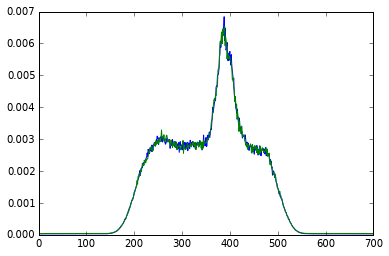

In [42]:
average = 300
ant1 = make_noise(bp, average)
ant2 = make_noise(bp, average)
for num, node in enumerate(sky):
    angle = (num/sky.shape[0])*pi
    delay = int(np.cos(angle) * baseline)
    print("{0}:{1}".format(num, delay), end=" ")
    sig = make_noise(node, average)
    delayed = np.hstack([np.zeros((average, np.abs(delay))), sig[:, :-np.abs(delay)]]) if delay != 0 else sig
    ant1 += sig if delay > 0 else delayed
    ant2 += delayed if delay > 0 else sig
plt.plot(average_spectrum(ant1))
plt.plot(average_spectrum(ant2))

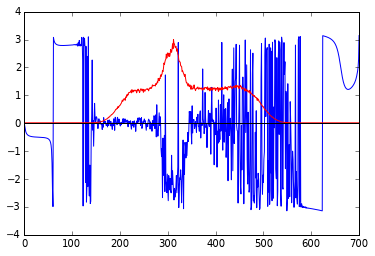

In [48]:
plt.plot(np.angle(np.average(np.fft.rfft(ant1)/np.fft.rfft(ant2), axis=0)))
s = np.average(np.abs(np.fft.rfft(ant1)), axis=0)
plt.plot(s/np.max(s)*3, 'r-')
plt.axhline(0, color="black")

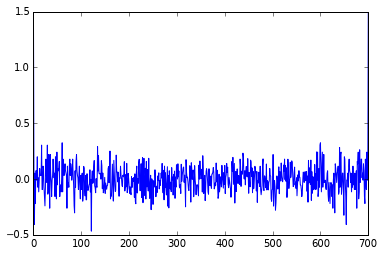

In [44]:
plt.plot(np.average(np.angle(np.fft.rfft(ant1)), axis=0))

In [13]:
# f in MHz, t in us -> everything consistent
# sample period = 112.5ns
sa = 20000
dt = 112.5e-3 # us
def discrete_noise_with_delay(delay):
    signal = np.zeros(sa)
    signal_p = np.zeros(sa)
    # undersampling
    time = np.linspace(0, dt*sa, sa)
    for freq in np.arange(1418, 1421, 0.05):
        w = freq * (2*pi)
        signal += np.sin(w*time)
        signal_p += np.sin(w*(time+delay))
    return signal, signal_p

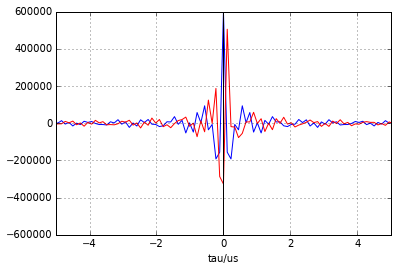

In [18]:
s, sp = discrete_noise_with_delay(0)
t = np.arange(-sa+1, sa, 1)*dt
plt.plot(t, np.correlate(s, sp, mode="full"), 'b-')
distance = 5 # meters
delay = distance / 0.3 # nanoseconds
s, sp = discrete_noise_with_delay(delay*1e-3)
plt.plot(t, np.correlate(s, sp, mode="full"), 'r-')
plt.xlim(-5, 5)
plt.grid()
plt.xlabel("tau/us")
plt.axvline(0, color="black")

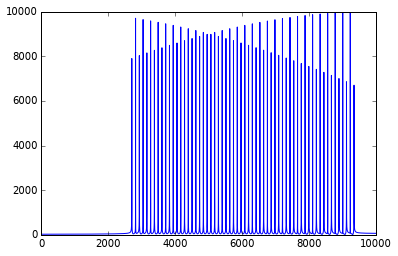

In [15]:
plt.plot(np.abs(np.fft.rfft(s)))

In [16]:
def fringe_rate(distance, elevation):
    # per minute
    wl = 0.21
    dist_wl = distance / wl
    effective_dist_wl = np.cos(elevation) * dist_wl
    effective_dist_wl_1min = np.cos(elevation + 4./57) * dist_wl
    return abs(effective_dist_wl - effective_dist_wl_1min)

In [17]:
fringe_rate(10, 60/57.)

2.9586904533489395

In [19]:
t = np.arange(0, 1000, 1)

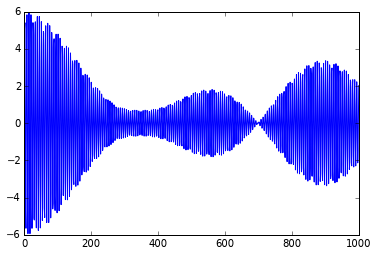

In [44]:
plt.plot(np.sin(t)+np.sin(1.01*t)+np.sin(1.021*t)+np.sin(1.007*t)+np.sin(1.015*t)+np.sin(1.013*t))
#plt.plot((np.sin(t)+np.sin(1.01*t))[1:], 'r-')
#plt.plot(np.sin(t))
#plt.xlim(0, 50)

0.486283534732


(100, 200)

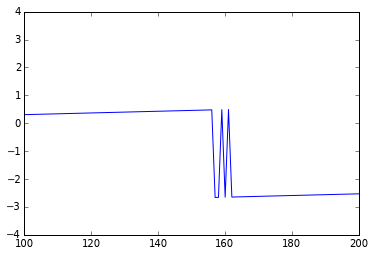

In [56]:
s = np.fft.rfft(np.cos(t)*np.hamming(len(t)))
print(np.angle(s[np.argmax(np.abs(s))]))
plt.plot(np.angle(s))
plt.xlim(100, 200)

In [47]:
offset = 1/11.25e6
phase_dur = 1/149e6
shift = offset / phase_dur
print(shift)

13.244444444444445
